In [1]:
import sys
sys.path.append("/home/fehrdelt/data_ssd/MedicalImaging_GIN/gradient_boosting")

import os
import lightgbm as lgb
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report


from sklearn.impute import SimpleImputer

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import HistGradientBoostingClassifier

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

from sklearn.manifold import TSNE
import umap

import matplotlib.pyplot as plt




/data_local/data_ssd/fehrdelt/environments/general_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
DATA_DIRECTORY = "/home/fehrdelt/data_ssd/data/clinical_data/Full/"

In [3]:
X_volumes_clinical = pd.read_csv(DATA_DIRECTORY+"combined_clinical_data_volumes_outcome_matlab_ANTS_hist_match.csv", usecols=range(2,31))
X_volumes_clinical.head()

,supratentorial_IPH,supratentorial_SAH,supratentorial_Petechiae,supratentorial_Edema,infratentorial_IPH,infratentorial_SAH,infratentorial_Petechiae,infratentorial_Edema,brainstem_IPH,brainstem_SAH,...,pression_arterielle_diastolique_PAD_arrivee_du_smur,score_glasgow_initial,score_glasgow_moteur_initial,anomalie_pupillaire_prehospitalier,frequence_cardiaque_FC_arrivee_du_smur,arret_cardio_respiratoire_massage,penetrant_objet,ischemie_du_membre,hemorragie_externe,amputation
0,0,339,0,0,0,15,0,0,0,0,...,49.0,15.0,6.0,0.0,56.0,0.0,0.0,0.0,0.0,0.0
1,0,0,0,0,0,0,0,0,0,0,...,60.0,15.0,6.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0
2,0,71,0,0,0,0,0,0,0,0,...,64.0,14.0,6.0,0.0,120.0,0.0,0.0,0.0,0.0,0.0
3,0,292,0,0,0,0,0,0,0,0,...,71.0,15.0,6.0,0.0,107.0,0.0,0.0,0.0,0.0,0.0
4,0,14,0,15,0,0,0,0,0,0,...,79.0,NaN,NaN,0.0,83.0,0.0,0.0,0.0,0.0,0.0


In [4]:
X_clinical_only = pd.read_csv(DATA_DIRECTORY+"combined_clinical_data_volumes_outcome_matlab_ANTS_hist_match.csv", usecols=range(16,31))
X_clinical_only.head()

,age,hemocue_initial,fracas_du_bassin,catecholamines,pression_arterielle_systolique_PAS_arrivee_du_smur,pression_arterielle_diastolique_PAD_arrivee_du_smur,score_glasgow_initial,score_glasgow_moteur_initial,anomalie_pupillaire_prehospitalier,frequence_cardiaque_FC_arrivee_du_smur,arret_cardio_respiratoire_massage,penetrant_objet,ischemie_du_membre,hemorragie_externe,amputation
0,52.0,NaN,0.0,0.0,87.0,49.0,15.0,6.0,0.0,56.0,0.0,0.0,0.0,0.0,0.0
1,23.0,NaN,0.0,0.0,100.0,60.0,15.0,6.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0
2,42.0,13.1,0.0,0.0,101.0,64.0,14.0,6.0,0.0,120.0,0.0,0.0,0.0,0.0,0.0
3,34.0,15.8,0.0,0.0,110.0,71.0,15.0,6.0,0.0,107.0,0.0,0.0,0.0,0.0,0.0
4,22.0,NaN,0.0,0.0,114.0,79.0,NaN,NaN,0.0,83.0,0.0,0.0,0.0,0.0,0.0


In [5]:
y = pd.read_csv(DATA_DIRECTORY+"combined_clinical_data_volumes_outcome_matlab_ANTS_hist_match.csv", usecols=[31])
y.head()

,outcome_neurochir_pic
0,0.0
1,0.0
2,0.0
3,0.0
4,0.0


In [6]:
nan_indexes = y.loc[pd.isna(y["outcome_neurochir_pic"]), :].index # indexes where there is a nan value.
print(nan_indexes)

y = y.dropna()
X_volumes_clinical = X_volumes_clinical.drop(nan_indexes)
X_clinical_only = X_clinical_only.drop(nan_indexes)

Index([76, 102, 104, 113, 118, 125], dtype='int64')


In [7]:
imp = SimpleImputer(missing_values=np.nan, strategy="median")

imp.fit(X_volumes_clinical)
X_volumes_clinical = imp.transform(X_volumes_clinical)

imp.fit(X_clinical_only)
X_clinical_only = imp.transform(X_clinical_only)

In [9]:
print(len(y))
print(len(X_volumes_clinical))

495
495


In [10]:
y = y['outcome_neurochir_pic'].to_numpy()
y = [int(i) for i in y]

#### Training without dealing with class imbalance

Clinical data only

In [23]:
#model = DecisionTreeClassifier()
model = HistGradientBoostingClassifier(categorical_features=[False, False, True, True, False, False, False, False, True, False, True, True, True, True, True])

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

#scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
scores = cross_validate(model, X_clinical_only, y, scoring=['roc_auc', 'recall_macro', 'f1'], cv=cv, n_jobs=-1)

#print(scores)

print("5 fold cross validation")
print(f'Mean ROC AUC: {np.mean(scores["test_roc_auc"])}, std: {np.std(scores["test_roc_auc"])}')
print(f'Mean recall macro: {np.mean(scores["test_recall_macro"])}, std: {np.std(scores["test_recall_macro"])}')
print(f'f1 score: {np.mean(scores["test_f1"])}, std: {np.std(scores["test_f1"])}')

5 fold cross validation
Mean ROC AUC: 0.8155107855107856, std: 0.05209806147754629
Mean recall macro: 0.5837739112739112, std: 0.06391323132180331
f1 score: 0.23754930254930254, std: 0.13144869083547778


Segmentation volumes and clinical data

In [24]:
#model = DecisionTreeClassifier()
model = HistGradientBoostingClassifier(categorical_features=[False]*14 + [False, False, True, True, False, False, False, False, True, False, True, True, True, True, True])

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

#scores = cross_val_score(model, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
scores = cross_validate(model, X_volumes_clinical, y, scoring=['roc_auc', 'recall_macro', 'f1'], cv=cv, n_jobs=-1)

#print(scores)

print("5 fold cross validation")
print(f'Mean ROC AUC: {np.mean(scores["test_roc_auc"])}, std: {np.std(scores["test_roc_auc"])}')
print(f'Mean recall macro: {np.mean(scores["test_recall_macro"])}, std: {np.std(scores["test_recall_macro"])}')
print(f'f1 score: {np.mean(scores["test_f1"])}, std: {np.std(scores["test_f1"])}')

5 fold cross validation
Mean ROC AUC: 0.8673465834576944, std: 0.04391649331473442
Mean recall macro: 0.5959472934472936, std: 0.055898743505045125
f1 score: 0.2816572316572316, std: 0.13865943022290605


#### With SMOTE oversampling and randomUnderSampling
SMOTE(sampling_strategy=0.1) & RandomUnderSampler(sampling_strategy=0.5)

Using imblearn.Pipeline, the over and undersampling is only applied during fit

Text(0, 0.5, 't_SNE component 2')

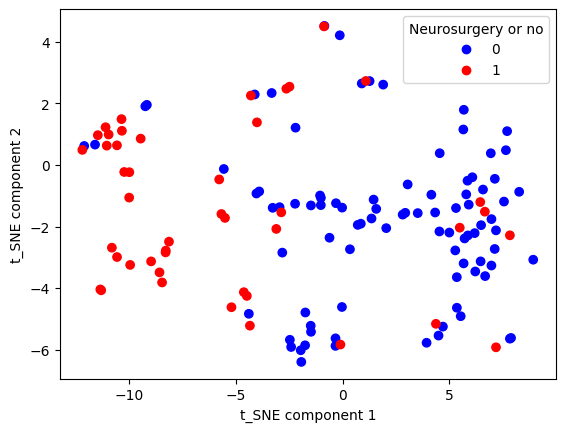

In [25]:
oversample = SMOTE()
pipeline_visu_smote_under = Pipeline(steps=[('over', SMOTE(sampling_strategy=0.1)), ('under', RandomUnderSampler(sampling_strategy=0.5))])
X_over_under_visu, y_over_under_visu = pipeline_visu_smote_under.fit_resample(X_volumes_clinical, y)

tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(X_over_under_visu)

fig, ax = plt.subplots()

scatter = ax.scatter(tsne_results[:, 0], tsne_results[:, 1], c=y_over_under_visu, cmap='bwr')
legend = ax.legend(*scatter.legend_elements(), title="Neurosurgery or no")
plt.xlabel('t_SNE component 1')
plt.ylabel('t_SNE component 2')

Text(0, 0.5, 'UMAP component 2')

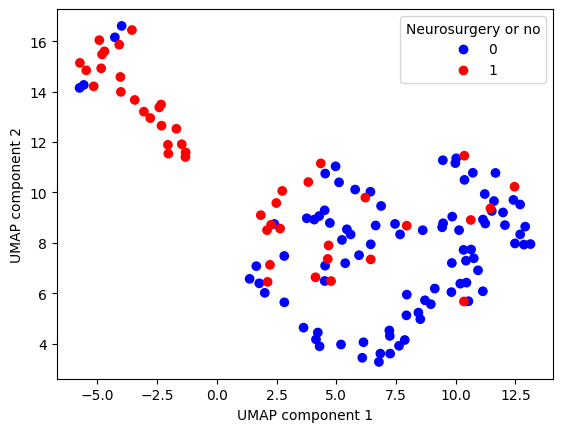

In [43]:
umap_model = umap.UMAP(n_neighbors=5, min_dist=0.6, n_components=2)
X_umap_over_under = umap_model.fit_transform(X_over_under_visu)


fig, ax = plt.subplots()

scatter = ax.scatter(X_umap_over_under[:, 0], X_umap_over_under[:, 1], c=y_over_under_visu, cmap='bwr')
legend = ax.legend(*scatter.legend_elements(), title="Neurosurgery or no")
plt.xlabel('UMAP component 1')
plt.ylabel('UMAP component 2')

https://scikit-learn.org/stable/modules/cross_validation.html

https://scikit-learn.org/stable/modules/grid_search.html 

In [32]:
#pipeline = Pipeline(steps=[('over', SMOTE()), ('model', DecisionTreeClassifier())])
pipeline_smote_under = Pipeline(steps=[('over', SMOTE(sampling_strategy=0.1)), ('under', RandomUnderSampler(sampling_strategy=0.5)), ('model', HistGradientBoostingClassifier(categorical_features=[False]*14+[False, False, True, True, False, False, False, False, True, False, True, True, True, True, True]))])

cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)

#scores = cross_val_score(pipeline, X, y, scoring='roc_auc', cv=cv, n_jobs=-1)
scores_smote_undersampling = cross_validate(pipeline_smote_under, X_volumes_clinical, y, scoring=['roc_auc', 'recall_macro', 'f1', "neg_brier_score"], cv=cv, n_jobs=-1)

print('Mean ROC AUC: %.3f' % np.mean(scores_smote_undersampling['test_roc_auc']))
print('Mean recall macro: %.3f' % np.mean(scores_smote_undersampling['test_recall_macro']))
print('f1 score: %.3f' % np.mean(scores_smote_undersampling['test_f1']))
print('Brier score: %.3f' % -np.mean(scores_smote_undersampling['test_neg_brier_score']))

Mean ROC AUC: 0.866
Mean recall macro: 0.761
f1 score: 0.434
Brier score: 0.109


#### Test inference

In [14]:
categorical = [False]*14 + [False, False, True, True, False, False, False, False, True, False, True, True, True, True, True]
clf_clinical_volumes = HistGradientBoostingClassifier(categorical_features=categorical).fit(X_volumes_clinical_dev, y_dev)
y_pred = clf_clinical_volumes.predict(X_volumes_clinical_test)
print(y_pred)
print(classification_report(y_pred=y_pred, y_true=y_test))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0]
              precision    recall  f1-score   support

           0       0.94      0.97      0.95        30
           1       0.00      0.00      0.00         2

    accuracy                           0.91        32
   macro avg       0.47      0.48      0.48        32
weighted avg       0.88      0.91      0.89        32



In [15]:
categorical = [False, False, True, True, False, False, False, False, True, False, True, True, True, True, True]
clf_clinical_only = HistGradientBoostingClassifier(categorical_features=categorical).fit(X_clinical_only_dev, y_dev)
y_pred = clf_clinical_only.predict(X_clinical_only_test)
print(y_pred)
print(classification_report(y_pred=y_pred, y_true=y_test))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
              precision    recall  f1-score   support

           0       0.94      1.00      0.97        30
           1       0.00      0.00      0.00         2

    accuracy                           0.94        32
   macro avg       0.47      0.50      0.48        32
weighted avg       0.88      0.94      0.91        32



/data_local/data_ssd/fehrdelt/environments/general_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data_local/data_ssd/fehrdelt/environments/general_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/data_local/data_ssd/fehrdelt/environments/general_env/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this 